In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
sys.path.append("../../src/")
sys.path.append("../../src/model")

from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif

import scipy as sp
from matplotlib import pyplot as plt

import wandb
wandb.login(host="https://api.wandb.ai") 


/home/ueharam1/miniconda3/envs/testgrelu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: masatoshi136 (masa136). Use `wandb login --relogin` to force relogin


True

# Load Pre-trained Model 

In [2]:
run = wandb.init()
artifact = run.use_artifact('fderc_diffusion/Diffusion-DNA-RNA/UTR-Model:v0')
dir = artifact.download()
wandb.finish()


class ModelParameters:
    diffusion_weights_file = 'artifacts/UTR-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    time_schedule = "artifacts/UTR-dataset:v0/time_dependent.npz"
    checkpoint_path = 'artifacts/UTR-Model:v0/diffusion_unconditional_epoch=075.ckpt'
config = ModelParameters() 
DEVICE = "cuda:2" # Any number is fine

wandb: Downloading large artifact UTR-Model:v0, 1499.65MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:2.1


In [3]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [4]:
# Load Reward model
from grelu.lightning import LightningModel

model = LightningModel.load_from_checkpoint("artifacts/UTR-Model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


## Start Fine-Tuning Diffusion Models 

In [5]:
from src.model import ddsm_PPO  as fine_tune

import os
save_name = "./log_finetune_PPO/"
isExist = os.path.exists(save_name)
if not isExist:
   os.makedirs(save_name)


loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate =3e-3, num_epoch = 400, length = 50, num_steps = 50, accmu = 4,
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

100%|██████████| 50/50 [00:01<00:00, 32.83it/s]


-0.093607097864151


100%|██████████| 50/50 [00:01<00:00, 36.01it/s]


-0.0539022795855999


100%|██████████| 50/50 [00:01<00:00, 36.30it/s]


-0.05979406461119652


100%|██████████| 50/50 [00:01<00:00, 35.17it/s]


-0.016387619078159332


100%|██████████| 50/50 [00:01<00:00, 33.21it/s]


0.08198007196187973


100%|██████████| 50/50 [00:01<00:00, 35.74it/s]


0.07776749134063721


100%|██████████| 50/50 [00:01<00:00, 36.68it/s]


0.08390823006629944


100%|██████████| 50/50 [00:01<00:00, 33.38it/s]


-0.041931718587875366


100%|██████████| 50/50 [00:01<00:00, 36.55it/s]


-0.23232989013195038


100%|██████████| 50/50 [00:01<00:00, 35.81it/s]


-0.14865915477275848


100%|██████████| 50/50 [00:01<00:00, 33.35it/s]


-0.05320519208908081


100%|██████████| 50/50 [00:01<00:00, 35.49it/s]


-0.010541107505559921


100%|██████████| 50/50 [00:01<00:00, 36.41it/s]


-0.07215788960456848


100%|██████████| 50/50 [00:01<00:00, 37.35it/s]


0.12385587394237518


100%|██████████| 50/50 [00:01<00:00, 33.97it/s]


0.03170732036232948


100%|██████████| 50/50 [00:01<00:00, 33.95it/s]


0.13975749909877777


100%|██████████| 50/50 [00:01<00:00, 36.24it/s]


0.14654295146465302


100%|██████████| 50/50 [00:01<00:00, 36.51it/s]


0.17936594784259796


100%|██████████| 50/50 [00:01<00:00, 31.67it/s]


0.12722653150558472


100%|██████████| 50/50 [00:01<00:00, 36.40it/s]


0.1447390913963318


100%|██████████| 50/50 [00:01<00:00, 36.55it/s]


0.26272180676460266


100%|██████████| 50/50 [00:01<00:00, 32.95it/s]


0.4696967899799347


100%|██████████| 50/50 [00:01<00:00, 35.28it/s]


0.39761072397232056


100%|██████████| 50/50 [00:01<00:00, 36.37it/s]


1.027702808380127


100%|██████████| 50/50 [00:01<00:00, 35.49it/s]


1.028461217880249


100%|██████████| 50/50 [00:01<00:00, 35.26it/s]


1.0377557277679443


100%|██████████| 50/50 [00:01<00:00, 36.19it/s]


1.0351324081420898


100%|██████████| 50/50 [00:01<00:00, 34.71it/s]


1.0369904041290283


100%|██████████| 50/50 [00:01<00:00, 33.96it/s]


1.0478723049163818


100%|██████████| 50/50 [00:01<00:00, 35.60it/s]


1.0170085430145264


100%|██████████| 50/50 [00:01<00:00, 35.20it/s]


0.9164496660232544


100%|██████████| 50/50 [00:01<00:00, 33.18it/s]


0.9993910789489746


100%|██████████| 50/50 [00:01<00:00, 35.88it/s]


1.0408823490142822


100%|██████████| 50/50 [00:01<00:00, 36.18it/s]


1.0336281061172485


100%|██████████| 50/50 [00:01<00:00, 31.19it/s]


1.0335655212402344


100%|██████████| 50/50 [00:01<00:00, 36.40it/s]


1.039017915725708


100%|██████████| 50/50 [00:00<00:00, 66.17it/s]


1.0491890907287598


100%|██████████| 50/50 [00:00<00:00, 66.66it/s]


1.049037218093872


100%|██████████| 50/50 [00:01<00:00, 37.09it/s]


0.8261951208114624


100%|██████████| 50/50 [00:00<00:00, 66.50it/s]


0.7261002063751221


100%|██████████| 50/50 [00:00<00:00, 66.67it/s]


0.7485535144805908


100%|██████████| 50/50 [00:00<00:00, 66.88it/s]


0.7677001953125


100%|██████████| 50/50 [00:00<00:00, 66.79it/s]


0.7678109407424927


100%|██████████| 50/50 [00:00<00:00, 66.67it/s]


0.7677959203720093


100%|██████████| 50/50 [00:00<00:00, 66.55it/s]


0.7677809596061707


100%|██████████| 50/50 [00:00<00:00, 66.35it/s]


0.7677979469299316


100%|██████████| 50/50 [00:00<00:00, 66.23it/s]


0.7678025960922241


100%|██████████| 50/50 [00:00<00:00, 66.72it/s]


0.7677918672561646


100%|██████████| 50/50 [00:00<00:00, 66.65it/s]


0.7677866816520691


100%|██████████| 50/50 [00:00<00:00, 66.76it/s]


0.7677921056747437


100%|██████████| 50/50 [00:00<00:00, 66.71it/s]


0.7677744030952454


100%|██████████| 50/50 [00:00<00:00, 66.46it/s]


0.7677748203277588


100%|██████████| 50/50 [00:00<00:00, 66.57it/s]


0.767799973487854


100%|██████████| 50/50 [00:00<00:00, 66.55it/s]


0.7677716016769409


100%|██████████| 50/50 [00:00<00:00, 66.78it/s]


0.767778754234314


100%|██████████| 50/50 [00:00<00:00, 66.55it/s]


0.7678053379058838


100%|██████████| 50/50 [00:00<00:00, 66.86it/s]


0.7677733898162842


100%|██████████| 50/50 [00:00<00:00, 66.48it/s]


0.7676479816436768


100%|██████████| 50/50 [00:00<00:00, 66.63it/s]


0.7654789686203003


100%|██████████| 50/50 [00:00<00:00, 66.66it/s]


0.7613867521286011


100%|██████████| 50/50 [00:00<00:00, 66.98it/s]


0.7745516300201416


100%|██████████| 50/50 [00:00<00:00, 66.71it/s]


0.8421664834022522


100%|██████████| 50/50 [00:00<00:00, 66.77it/s]


0.7841044664382935


100%|██████████| 50/50 [00:00<00:00, 66.38it/s]


0.6142284870147705


100%|██████████| 50/50 [00:00<00:00, 66.51it/s]


0.4892839193344116


100%|██████████| 50/50 [00:00<00:00, 66.60it/s]


0.4577106833457947


100%|██████████| 50/50 [00:00<00:00, 66.64it/s]


0.8168200254440308


100%|██████████| 50/50 [00:00<00:00, 55.04it/s]


0.9002389311790466


100%|██████████| 50/50 [00:00<00:00, 66.86it/s]


0.8831311464309692


100%|██████████| 50/50 [00:00<00:00, 66.51it/s]


0.7803572416305542


100%|██████████| 50/50 [00:00<00:00, 66.63it/s]


0.725957989692688


100%|██████████| 50/50 [00:00<00:00, 66.79it/s]


0.8710960149765015


100%|██████████| 50/50 [00:00<00:00, 66.67it/s]


0.7929440140724182


100%|██████████| 50/50 [00:00<00:00, 67.29it/s]


0.7499601244926453


100%|██████████| 50/50 [00:00<00:00, 66.80it/s]


0.8778568506240845


100%|██████████| 50/50 [00:00<00:00, 66.40it/s]


0.8749969601631165


100%|██████████| 50/50 [00:00<00:00, 66.79it/s]


0.9011806845664978


100%|██████████| 50/50 [00:00<00:00, 66.78it/s]


1.0977369546890259


100%|██████████| 50/50 [00:00<00:00, 66.70it/s]


0.9756740927696228


100%|██████████| 50/50 [00:00<00:00, 66.75it/s]


0.8935947418212891


100%|██████████| 50/50 [00:00<00:00, 66.84it/s]


1.0234729051589966


100%|██████████| 50/50 [00:00<00:00, 66.90it/s]


1.0417101383209229


100%|██████████| 50/50 [00:00<00:00, 66.71it/s]


1.0669455528259277


100%|██████████| 50/50 [00:00<00:00, 66.65it/s]


1.0559083223342896


100%|██████████| 50/50 [00:00<00:00, 66.67it/s]


1.052657127380371


100%|██████████| 50/50 [00:00<00:00, 66.69it/s]


1.0760927200317383


100%|██████████| 50/50 [00:00<00:00, 66.71it/s]


1.0760669708251953


100%|██████████| 50/50 [00:00<00:00, 66.45it/s]


1.0761319398880005


100%|██████████| 50/50 [00:00<00:00, 66.76it/s]


1.0763676166534424


100%|██████████| 50/50 [00:00<00:00, 66.64it/s]


1.0764174461364746


100%|██████████| 50/50 [00:00<00:00, 57.33it/s]


1.0764861106872559


100%|██████████| 50/50 [00:00<00:00, 66.65it/s]


1.07643723487854


100%|██████████| 50/50 [00:00<00:00, 66.38it/s]


1.0763583183288574


100%|██████████| 50/50 [00:00<00:00, 66.14it/s]


1.0763914585113525


100%|██████████| 50/50 [00:00<00:00, 65.88it/s]


1.0764312744140625


100%|██████████| 50/50 [00:00<00:00, 66.28it/s]


1.0764646530151367


100%|██████████| 50/50 [00:00<00:00, 66.45it/s]


1.0765151977539062


100%|██████████| 50/50 [00:00<00:00, 67.93it/s]


1.0765444040298462


100%|██████████| 50/50 [00:00<00:00, 65.99it/s]


1.076564908027649


100%|██████████| 50/50 [00:00<00:00, 66.51it/s]


1.0765550136566162


reward,▁▁▂▁▁▁▂▃▃▄██▇██▇▆▆▆▆▆▆▆▆▆▅▆▇▇▆▇▇████████
reward,1.07656


# Evaluation

In [12]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("log_finetune_PPO/_127.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 


ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [13]:
### Get Samples from Fine-tuned Models

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 137.35it/s]


In [14]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [15]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 137.55it/s]


In [16]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

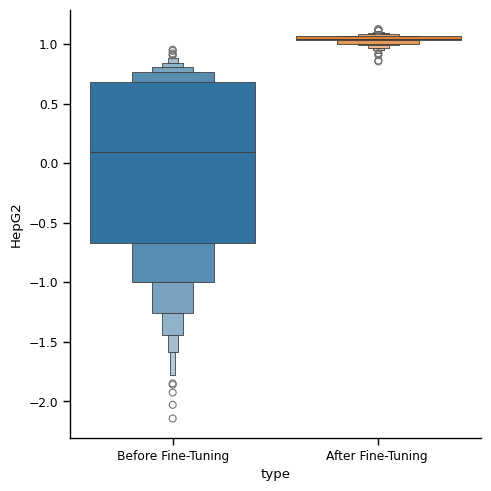

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")


